# Case Study - Recommendation Systems Part 2

---------------
## Context
---------------

Yelp was founded in 2004 to help people find great local businesses like businesses, hairstylists, etc. Today, the website and their mobile application publish crowd-sourced reviews about local businesses as well as certain metadata about them that can help in customer's decision making process. Yelp uses automated software to recommend the most helpful and reliable reviews for the Yelp community out of such a large and diverse dataset.

The Yelp dataset is a large collection of user reviews, business metadata, business check-ins, users' social network data, user tips for businesses across 10 cities spread across 4 countries. The original dataset is very huge with ~ 11GB of data. In this case study, we will only use a subset of data due to hardware limitations.

-----------------
## Objective
-----------------

In this case study, we will build three types of recommendation systems: 
- **Clustering based recommendation system**
- **Content based collaborative filtering**

-----------------
## Dataset
-----------------

We will only use the following four attributes from the **yelp_reviews dataset**: 
- business_id
- business_name
- stars
- user_id
- text: The text review by the user

### Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity

### Loading data

In [2]:
reviews = pd.read_csv('yelp_reviews.csv', usecols=['user_id', 'business_id', 'business_name', 'stars', 'text'])
reviews.head()

,business_id,business_name,stars,text,user_id
0,9yKzy9PApeiPPOUJEtnvkg,Morning Glory Cafe,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,Spinato's Pizzeria,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,Haji-Baba,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,Chaparral Dog Park,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,Discount Tire,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw


In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   business_id    229907 non-null  object
 1   business_name  229907 non-null  object
 2   stars          229907 non-null  int64 
 3   text           229901 non-null  object
 4   user_id        229907 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.8+ MB


- There are **2,29,907 observations** and **4 columns** in the data
- There are **no missing values** in the data
- All the columns are of **object data type** except the **stars column** which is of **numeric data type**
- The columns **business_id** and **user_id** are encrypted to provide anonymity. To ease our processing of the dataset we will use **label encodings** to process these two variables.

In [4]:
#Label Encoding
le = LabelEncoder()
reviews['user_id'] = le.fit_transform(reviews['user_id'])
reviews['business_id'] = le.fit_transform(reviews['business_id'])

In [5]:
reviews.head()

,business_id,business_name,stars,text,user_id
0,2030,Morning Glory Cafe,5,My wife took me here on my birthday for breakf...,39808
1,6654,Spinato's Pizzeria,5,I have no idea why some people give bad review...,1179
2,1470,Haji-Baba,4,love the gyro plate. Rice is so good and I als...,1279
3,6753,Chaparral Dog Park,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",42067
4,1471,Discount Tire,5,General Manager Scott Petello is a good egg!!!...,42785


### Clustering based recommendation system

In clustering-based recommendation systems, we explore the similarities and differences in people's tastes in businesses based on how they rate different businesses. We cluster similar users together and recommend businesses to a user based on stars from other users in the same cluster.

Let us first create the **user-item interactions matrix**. Since this dataset is big, we will make a shorter version of this dataset by filtering to 1000 most rated businesses and top 1000 users who have interacted the most.

In [6]:
#Finding IDs of top 1000 businesses
top_1000_businesses = pd.DataFrame({'business_id':reviews['business_id'].value_counts()[:1000].index})
top_1000_businesses.head()

,business_id
0,8254
1,5947
2,3830
3,9425
4,2852


In [7]:
#Finding IDs of top 1000 users
top_1000_users = pd.DataFrame({'user_id':reviews[reviews['business_id'].isin(top_1000_businesses['business_id'])]['user_id'].value_counts()[:1000].index})
top_1000_users.head()

,user_id
0,31258
1,7236
2,4179
3,1196
4,3371


In [8]:
#Filtering the original data to contain only top 1000 businesses
reviews_small = top_1000_businesses.merge(reviews, how='inner', on='business_id')
reviews_small.shape

(123460, 5)

In [9]:
#Filtering the data with top 1000 businesses to contain only top 1000 users
reviews_small = top_1000_users.merge(reviews_small, how='inner', on='user_id')
reviews_small.shape

(42934, 5)

In [10]:
reviews_small.head()

,user_id,business_id,business_name,stars,text
0,31258,8254,Phoenix Sky Harbor International Airport,3,I'm not sure how I've gone this long without r...
1,31258,3830,Four Peaks Brewing Co,4,After reading all of the awesome reviews that ...
2,31258,9425,Matt's Big Breakfast,4,"Believe it or not, I finally had my first Matt..."
3,31258,2852,FEZ,5,Jared suggest we stop by Fez to say hello to T...
4,31258,5852,Cibo,5,"Wow - \nI must admit, Cibo impressed me more t..."


Let's compute the **user-item interactions matrix**

In [11]:
interactions_matrix = reviews_small.pivot(index='user_id', columns='business_id', values='stars')

In [12]:
interactions_matrix

business_id,11,12,13,36,39,51,88,103,126,140,...,11433,11446,11495,11504,11506,11509,11517,11521,11529,11531
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN,3.0
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45742,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- There are **1000** unique businesses and **1000** unique users present in the above dataset. So, there is a possibility of 1000 * 1000 = 10,00,000 user-business stars. But we only have a total of **42934**, which is why we are getting a **sparse** user business interactions matrix above with the majority of the values being **NaN**

To create a **dense** version of the above matrix, let's sort by the most rated businesses, and the users who have rated the most number of businesses.

In [13]:
def find_most_rated_businesses(interactions_matrix, num_businesses):
    
    #Appending the count of stars for each business as a row in the interaction matrix
    user_business_stars = interactions_matrix.append(interactions_matrix.count(), ignore_index=True)
    
    #Sorting the values in the interaction matrix on the basis of the appended row
    user_business_stars_sorted = user_business_stars.sort_values(len(user_business_stars)-1, axis=1, ascending=False)
    
    #Dropping the appended row from the sorted interaction matrix
    user_business_stars_sorted = user_business_stars_sorted.drop(user_business_stars_sorted.tail(1).index)
    
    #Selecting top businesses with the most number of stars
    most_rated_businesses = user_business_stars_sorted.iloc[:, :num_businesses]
                                                    
    return most_rated_businesses

In [14]:
#Finding 30 most rated businesses
most_rated_businesses = find_most_rated_businesses(interactions_matrix, 30)
most_rated_businesses

business_id,2852,5852,5947,3830,9425,175,9769,4656,5362,10548,...,2140,2185,8254,3122,7283,2336,472,9903,39,3057
0,NaN,2.0,4.0,5.0,NaN,4.0,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN
1,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,...,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,2.0,4.0,5.0,4.0,5.0,4.0,NaN,3.0,5.0,3.0,...,3.0,NaN,4.0,NaN,4.0,NaN,5.0,2.0,5.0,3.0
997,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [15]:
def find_most_interacted_users(most_rated_businesses, num_users):
    
    #Finding how many of the top 30 businesses have been rated by the user 
    most_rated_businesses['counts'] = pd.Series(most_rated_businesses.count(axis=1))
    
    #Sorting the dataframe by the new 'counts' columns
    most_rated_businesses_users = most_rated_businesses.sort_values('counts', ascending=False)
    
    #Selecting top users with the most number of interactions
    most_rated_businesses_users_selected = most_rated_businesses_users.iloc[:num_users, :]
    
    #Dropping the 'counts' column
    most_rated_businesses_users_selected.drop(['counts'], axis=1, inplace=True)
    
    return most_rated_businesses_users_selected

In [16]:
#Finding top 18 users with the most number of interactions
most_rated_businesses_users_selected = find_most_interacted_users(most_rated_businesses, 18)
most_rated_businesses_users_selected

business_id,2852,5852,5947,3830,9425,175,9769,4656,5362,10548,...,2140,2185,8254,3122,7283,2336,472,9903,39,3057
996,2.0,4.0,5.0,4.0,5.0,4.0,NaN,3.0,5.0,3.0,...,3.0,NaN,4.0,NaN,4.0,NaN,5.0,2.0,5.0,3.0
939,4.0,4.0,4.0,NaN,4.0,4.0,4.0,4.0,4.0,3.0,...,3.0,2.0,NaN,NaN,NaN,5.0,NaN,4.0,NaN,3.0
681,5.0,5.0,NaN,4.0,4.0,NaN,4.0,NaN,5.0,4.0,...,4.0,4.0,3.0,4.0,4.0,5.0,NaN,5.0,5.0,NaN
856,4.0,4.0,5.0,NaN,NaN,4.0,4.0,NaN,NaN,5.0,...,3.0,NaN,NaN,4.0,4.0,NaN,5.0,NaN,NaN,4.0
81,5.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,4.0,NaN,5.0,5.0,NaN,3.0,4.0
144,5.0,NaN,2.0,5.0,NaN,4.0,3.0,4.0,NaN,3.0,...,3.0,NaN,4.0,3.0,3.0,5.0,NaN,NaN,NaN,5.0
668,4.0,5.0,NaN,NaN,5.0,5.0,5.0,4.0,4.0,NaN,...,5.0,5.0,NaN,NaN,5.0,4.0,NaN,NaN,5.0,3.0
329,3.0,3.0,4.0,4.0,NaN,2.0,3.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,4.0,NaN
683,4.0,5.0,2.0,NaN,5.0,5.0,5.0,NaN,NaN,5.0,...,4.0,2.0,NaN,NaN,5.0,NaN,4.0,5.0,NaN,NaN
783,NaN,2.0,1.0,NaN,4.0,4.0,4.0,NaN,4.0,4.0,...,4.0,4.0,2.0,3.0,NaN,5.0,2.0,NaN,5.0,NaN


Let's try to **visualize** the above matrix using a heatmap

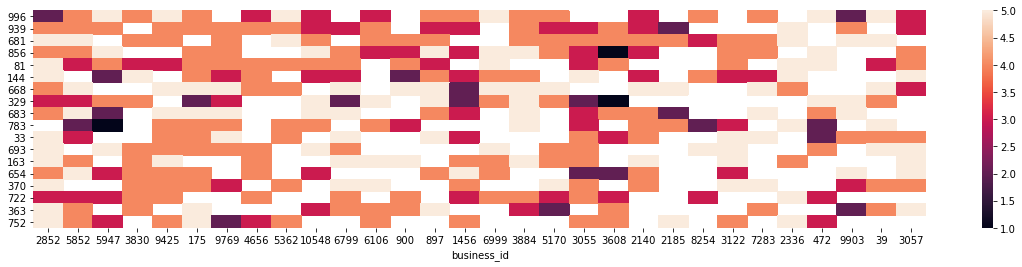

In [17]:
figure = plt.figure(figsize=(20, 4))
sns.heatmap(most_rated_businesses_users_selected);

- In the above heatmap, you can see that some **cells are white i.e. the respective user did not rate that business**. Those are represented by **NaN** in the interactions matrix.
- The majority of stars seem to be between 4 and 5

#### Choosing optimal K

We will try different values of k and calculate the **sum of squared errors (SSE) for each k**, then we will use the **elbow plot** to choose the optimal value of k.

First, we need to **replace missing values with 0** otherwise, we cannot build the clustering-based model.

In [18]:
interactions_matrix.fillna(0, inplace=True)

In [19]:
sse = [] #Empty list to store the sum of squared errors for each value of k

for k in range(2, 15, 1):
    
    kmeans = KMeans(n_clusters=k, random_state=42).fit(interactions_matrix)
    
    sse.append(kmeans.inertia_)

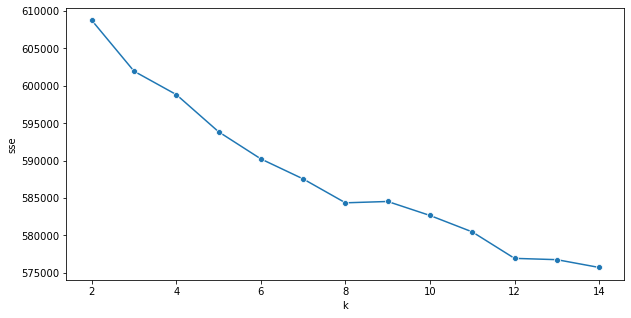

In [20]:
#Plotting elbow plot

error_data = pd.DataFrame({'k':range(2, 15, 1), 'sse':sse})

plt.figure(figsize=(10,5))

sns.lineplot(x='k', y='sse', data=error_data, marker='o')

plt.show()

- The elbow plot shows there is an elbow at **K=8** but there is a sharp decrease in the sum of squared errors at K=12. 
- We will consider the first elbow at K=8 for K-Means clustering.

In [21]:
most_rated_businesses

business_id,2852,5852,5947,3830,9425,175,9769,4656,5362,10548,...,2185,8254,3122,7283,2336,472,9903,39,3057,counts
0,NaN,2.0,4.0,5.0,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,11
1,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,...,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
996,2.0,4.0,5.0,4.0,5.0,4.0,NaN,3.0,5.0,3.0,...,NaN,4.0,NaN,4.0,NaN,5.0,2.0,5.0,3.0,22
997,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2


In [22]:
predictions = KMeans(n_clusters=8, random_state=42).fit_predict(interactions_matrix)
results = pd.concat([most_rated_businesses.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
results

,index,2852,5852,5947,3830,9425,175,9769,4656,5362,...,8254,3122,7283,2336,472,9903,39,3057,counts,group
0,0,NaN,2.0,4.0,5.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,11,1
1,1,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3,4
2,2,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5,4
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4
4,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6
996,996,2.0,4.0,5.0,4.0,5.0,4.0,NaN,3.0,5.0,...,4.0,NaN,4.0,NaN,5.0,2.0,5.0,3.0,22,5
997,997,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4
998,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2,6


Let's check the count of user in each cluster

In [23]:
results['group'].value_counts()

4    315
6    315
1    161
7     95
2     47
5     33
3     32
0      2
Name: group, dtype: int64

- The number of users is **unevenly distributed**. Cluster 4 and 6 comprise of the majority of users (about 63%) and cluster 0 has just 2 users. This might be because of the kmeans algorithm is not best suited for this data. You can also try out different clustering algorithms like - **hierarchical, DBSCAN, GMM, etc.** and try to find out better clusters.

We will not go in-depth for each cluster, but we can try to **visualize the 6th cluster** and check how sparse or dense the cluster is. It would be difficult to visualize large clusters, so let's plot **only 50 users and businesses with most interactions**. 

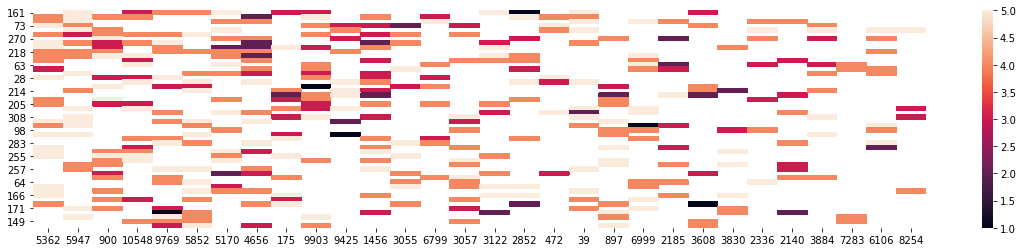

In [24]:
cluster_number = 6
n_users = 50
n_businesses = 50

#Filtering the dataframe to extract user in cluster 6
cluster_6_predictions = results[results.group == cluster_number].drop(['group', 'counts', 'index'], axis=1)

#Finding top 50 businesses with most number of interactions
cluster_6_businesses = find_most_rated_businesses(cluster_6_predictions, n_businesses)

#Finding top 5
0 users with most number of interactions 
cluster_6_users = find_most_interacted_users(cluster_6_businesses, n_users)

#PLotting heatmap
figure = plt.figure(figsize=(20, 4))
sns.heatmap(cluster_6_users);

- The heatmap shows that cluster 6 is **dense with some NaN values**. 
- The majority of businesses have been **rated 4 or above** by users in cluster 6

### Prediction

Now, as an example, let's **recommend businesses** to a user from cluster 6. Let's select the user in cluster 6 with most number of interactions.

In [25]:
find_most_interacted_users(cluster_6_predictions, 1).index

Int64Index([541], dtype='int64')

In [26]:
user_id = 541

user_id_stars  = cluster_6_predictions.loc[user_id, :]

user_id_unrated_businesses =  user_id_stars[user_id_stars.isnull()]

avg_stars = pd.concat([user_id_unrated_businesses, cluster_6_predictions.mean()], axis=1, join='inner').loc[:,0]

avg_stars = pd.DataFrame(avg_stars.sort_values(ascending=False).reset_index())

avg_stars.columns = ['business_id', 'avg_star']

business_name = reviews[reviews['business_id'].isin(user_id_unrated_businesses.index)][['business_id', 'business_name']].drop_duplicates().reset_index(drop=True)

business_name.merge(avg_stars, on='business_id').sort_values(by='avg_star', ascending=False)

,business_id,business_name,avg_star
1,6999,Lux,4.457143
11,5362,Postino Arcadia,4.414634
7,897,Postino Central,4.361111
6,2336,Sweet Republic,4.260870
2,3884,Lo-Lo's Chicken & Waffles,4.238095
14,3055,Ticoz Resto-Bar,4.209302
18,3057,Windsor,4.048780
17,900,Chelsea's Kitchen,4.000000
16,3830,Four Peaks Brewing Co,4.000000
5,472,Barrio Café,3.973684


The top 5 restaurants to recommend to user 541 based on clustering based recommendation would be:

In [27]:
business_name.merge(avg_stars, on='business_id').sort_values(by='avg_star', ascending=False).head(5)

,business_id,business_name,avg_star
1,6999,Lux,4.457143
11,5362,Postino Arcadia,4.414634
7,897,Postino Central,4.361111
6,2336,Sweet Republic,4.260870
2,3884,Lo-Lo's Chicken & Waffles,4.238095


### Content based recommendation system

In content-based recommendation system, we would be using the feature - **text** i.e. reviews to find out similar businesses

Text data generally contains pronunciation, stopwords, non-ASCII characters which makes it **very noisy**. So, we will first need to **pre-process the text** and then we will **generate features from the text to compute similarities** between the texts/reviews. Before that, let's see some terminology:

**stopwords:** A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that does not contain information in the text and can be ignored.
**Lemmatization:** Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analyzed as a single item. For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.

In [28]:
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
def tokenize(text):
    
    #Making each letter as lowercase and removing non-alphabetical text
    text = re.sub(r"[^a-zA-Z]"," ",text.lower())
    
    #Extracting each word in the text
    tokens = word_tokenize(text)
    
    #Removing stopwords
    words = [word for word in tokens if word not in stopwords.words("english")]
    
    #Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

### Feature Extraction

Below are some of the ways to extract features from texts - 
- Bag of words
- TF-IDF
- One hot encoding
- Word vectors

Here, we will be using **tfidf** as a feature extraction technique

In [30]:
#Selecting a random subset of the original data
reviews_small = reviews.sample(n=1000, random_state=42)
reviews_small = reviews_small.set_index('business_name')
indices = pd.Series(reviews_small.index)
indices[:5]

0                               Chi Chi's Tacos
1    Warner Village Cosmetic & Family Dentistry
2                                  The Herb Box
3                            Asian Cafe Express
4                            Studio Movie Grill
Name: business_name, dtype: object

In [31]:
tfidf = TfidfVectorizer(tokenizer=tokenize)
review_tfidf = tfidf.fit_transform(reviews_small['text'].values).toarray()

In [32]:
pd.DataFrame(review_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,8150,8151,8152,8153,8154,8155,8156,8157,8158,8159
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060862,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122573,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have extracted **9133 features** from the text data. Now, we can find similarities between businesses using these features. We will use cosine similarity to calculate the similarity.

In [33]:
similar_review = cosine_similarity(review_tfidf, review_tfidf)
similar_review

array([[1.        , 0.0344108 , 0.00381338, ..., 0.00954374, 0.        ,
        0.        ],
       [0.0344108 , 1.        , 0.03549241, ..., 0.0592041 , 0.00859173,
        0.03336436],
       [0.00381338, 0.03549241, 1.        , ..., 0.01793796, 0.00309585,
        0.04966309],
       ...,
       [0.00954374, 0.0592041 , 0.01793796, ..., 1.        , 0.        ,
        0.02083381],
       [0.        , 0.00859173, 0.00309585, ..., 0.        , 1.        ,
        0.09226887],
       [0.        , 0.03336436, 0.04966309, ..., 0.02083381, 0.09226887,
        1.        ]])

Finally, let's create a function to find most similar businesses to recommend for a given business

In [34]:
# function that takes in business title as input and returns the top 10 recommended businesses
def recommendations(title, similar_review):
    
    recommended_businesses = []
    
    indices = pd.Series(reviews_small.index)
    
    # getting the index of the business that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_review[idx]).sort_values(ascending = False)

    # getting the indices of 10 most similar businesses
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching businesses
    for i in top_10_indexes:
        recommended_businesses.append(list(reviews_small.index)[i])
        
    return recommended_businesses

In [35]:
recommendations('Asian Cafe Express', similar_review)

[232, 939, 363, 276, 43, 548, 628, 532, 875, 771]


["America's Taco Shop",
 "Saba's Mediterranean Cuisine",
 'Black Chile Mexican Grill',
 'Pho Da Lat',
 'El Mesquite Restaurant',
 'Little Shanghai',
 'China Grill',
 'Haji-Baba',
 'Da Vàng',
 'Mekong Palace']

- The Asian Cafe Express is a top rated restaurant in the subset reviews_small and the majority of our recommendations are restaurants with 4 or 5 stars which implies that the resulting recommendation system is working well.

### Conclusion

In this notebook, we have seen below recommendation techniques: 
- clustering based recommendation systems
- content based recommendation systems

We have see how they are different from each other and what kind of data is needed to build each of these two recommendation systems. We can further combine all the recommendation techniques we have see so far to create a hybrid recommendation system.